# Capstone Project : Book Recommendation System

This is the third notebook for capstone project. It conatins the following section.


### Contents:
- [Import Libraries](#Import-Library)
- [Data Import](#Data-Import)
- [Filtering Ratings Dataset](#Filtering-Rating-Dataset)
- [Modelling KNN algorithm](#Modelling-KNN-Algorithm)
- [Recommendation](#Test-our-model-and-make-some-recommendations)
- [Recommendation](#Collaborative-Filtering-Using-Matrix-Factorisation)



## Collaborative based Book Recommendation System 

Collaborative Filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular users. It looks at the items they like and combines them to create a ranked list of suggestions.
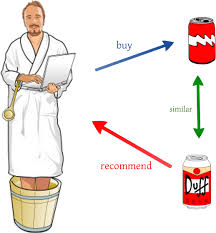

There are many ways to decide which users are similar and combine their choices to create a list of recommendations.

Book-Crossings is a book rating dataset compiled by Cai-Nicolas Ziegler. It contains 1.1 million ratings of 270,000 books by 90,000 users. The ratings are on a scale from 1 to 10

The data consists of three tables : ratings, books info and users info. 
In this notebook, we will cover various types of recommendation engine algorithms and fundamentals of creat



Dataset url: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

### Load the Libraries

In [967]:
# importing libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import warnings


## Load Datasets

In [968]:
#reading files
books = pd.read_csv('../Datasets/cleaned_books.csv')
users = pd.read_csv('../Datasets/cleaned_users.csv')
ratings = pd.read_csv('../Datasets/cleaned_ratings.csv')

In [969]:
#checking the books data using head function
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.000,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.000,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.000,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.000,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.000,W. W. Norton &; Company


In [1007]:
books.shape

(271358, 5)

In [970]:
#checking the users data using head function
users.head()

,userID,Age,city,state,country
0,8,nan,timmins,ontario,canada
1,9,nan,germantown,tennessee,usa
2,12,nan,fort bragg,california,usa
3,14,nan,mediapolis,iowa,usa
4,16,nan,albuquerque,new mexico,usa


In [1008]:
users.shape

(68091, 5)

### Ratings data

The ratings data set provides a list of ratings that users have given to books. It includes 1,149,780 records and 3 fields: userID, ISBN and bookRating. 

In [971]:
#checking the ratings data using head function
ratings.head()

,userID,ISBN,bookRating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276744,038550120X,7
4,276747,0060517794,9


In [1009]:
ratings.shape

(103270, 3)

### Ratings distribution
The ratings are very unevenly distributed and the vast majority of ratings are 0

To cope up with computing power my machine has and to reduce the dataset size, I am considering users who have rated atleast 100 books and books which have atleast 100 ratings.

In [972]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 100].index)]
ratings.head()

,userID,ISBN,bookRating
529,277427,002542730X,10
530,277427,003008685X,8
531,277427,0060006641,10
532,277427,0060542128,7
533,277427,0061009059,9


In [973]:
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]
ratings.head()

,userID,ISBN,bookRating
529,277427,002542730X,10
530,277427,003008685X,8
531,277427,0060006641,10
532,277427,0060542128,7
533,277427,0061009059,9


## Collaborative Filtering Using k-Nearest Neighbors(kNN)

Let us undersatnd this with an example. If person A likes to read 3 books, say The Lovely Bones, A Civil Action and A Painted House, and person B likes The Lovely Bones, A Civil Action and Daddy's Little Girl, then they have almost similar interests.

We can say with some certainity that A should like the Daddy's Little Girl and B should like A Painted House.

The collaborative filtering algorithm uses "User Behavior" for recommending items. This is one of the most commonly used algorithms in the industry as it is not dependent on any additional information. 

kNN is a machine learning algorithm to find the clusters of similar users based on common book ratings and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item(book) and one column for each user.

Starting from the original data set, we will be only lloking at the popular books. In order to find out which books are popular, we combine books data with ratings data.

In [974]:
combine_book_rating = pd.merge(ratings, books, on = 'ISBN')


In [975]:
columns = ['bookAuthor', 'yearOfPublication', 'publisher']
combine_book_rating = combine_book_rating.drop(columns, axis = 1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...


We then group by book titles and create a new column for total Rating count.

In [976]:
# getting the total rating count for each book which is rated
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])
combine_book_rating.head(10)

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
5,113270,002542730X,5,Politically Correct Bedtime Stories: Modern Ta...
6,128835,002542730X,8,Politically Correct Bedtime Stories: Modern Ta...
7,150979,002542730X,8,Politically Correct Bedtime Stories: Modern Ta...
8,164096,002542730X,8,Politically Correct Bedtime Stories: Modern Ta...
9,173291,002542730X,7,Politically Correct Bedtime Stories: Modern Ta...


In [977]:
book_ratingCount = combine_book_rating.groupby(by = ['bookTitle'])['bookRating'].count()


In [978]:
book_ratingCount

bookTitle
 A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)               1
 Dark Justice                                                                                                            1
 Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth                         1
 Final Fantasy Anthology: Official Strategy Guide (Brady Games)                                                          1
 Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750                                  2
 Highland Desire (Zebra Splendor Historical Romances)                                                                    1
 Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)                                                        1
 Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback))                                                       3
 Nonbo

In [979]:
# reset index
book_ratingCount = book_ratingCount.reset_index()
book_ratingCount.head()

,bookTitle,bookRating
0,A Light in the Storm: The Civil War Diary of ...,1
1,Dark Justice,1
2,Earth Prayers From around the World: 365 Pray...,1
3,Final Fantasy Anthology: Official Strategy Gu...,1
4,Good Wives: Image and Reality in the Lives of...,2


In [980]:
book_ratingCount = book_ratingCount.rename(columns = {'bookRating' : 'totalRatingCount'})[['bookTitle', 'totalRatingCount']]
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,1
1,Dark Justice,1
2,Earth Prayers From around the World: 365 Pray...,1
3,Final Fantasy Anthology: Official Strategy Gu...,1
4,Good Wives: Image and Reality in the Lives of...,2


We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [981]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16


In [1010]:
rating_with_totalRatingCount.shape

(103270, 5)

Let's look at the statisitcs of totalRatingCount

In [982]:
pd.set_option('display.float_format', lambda x: '%.3f' %x)
print(book_ratingCount['totalRatingCount'].describe())

count   61648.000
mean        1.675
std         2.278
min         1.000
25%         1.000
50%         1.000
75%         1.000
max        72.000
Name: totalRatingCount, dtype: float64


The median book has been rated only once. Let's look at the top of the distribution.

In [983]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    3.000
0.910    3.000
0.920    3.000
0.930    3.000
0.940    4.000
0.950    4.000
0.960    5.000
0.970    6.000
0.980    8.000
0.990   11.000
Name: totalRatingCount, dtype: float64


In [984]:
popularity_threshold = 10
user_rating= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')


In [985]:
user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
1,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16
2,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
3,52584,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,16
4,110934,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,16


In [1011]:
user_rating.shape

(13251, 5)

## Implementing KNN

We converted our table to a 2D matrix, and filled the missing values with zeros(since we will calculate distances between rating vectors). We then transform the values (ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

### Finding the Nearest Neighbors

We use unsupervised algorithm with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is "brute" and we specify "metric = cosine" so that the algorithm will calculate the cosine similarity between the rating vectors. Finally, we will fit the model.



Next key step in building CF-based recommendations system is to generate user-item ratings matrix from the user-ratings table.

In [986]:
# Dropping all the duplicates
user_rating = user_rating.drop_duplicates(['userID', 'bookTitle'])

In [1012]:
user_rating.shape

(13251, 5)

In [987]:
user_rating_pivot = user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating')
user_rating_pivot

userID,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,10.000,nan,nan,nan,nan,nan,nan
1st to Die: A Novel,nan,nan,nan,nan,nan,nan,nan,nan,9.000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2nd Chance,nan,nan,10.000,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
84 Charing Cross Road,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,10.000,nan,nan
A Bend in the Road,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000,...,nan,nan,nan,nan,5.000,nan,nan,nan,nan,nan
A Case of Need,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
"A Child Called \It\"": One Child's Courage to Survive""",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
A Confederacy of Dunces (Evergreen Book),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
A Darkness More Than Night,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [1013]:
user_rating_pivot.shape

(831, 440)

Notice that most of the values in user_rating matrix are NaNs indicating the absence of ratings and hence sparsity of data. As most of the machine learning algorithms cannot handle NaNs, we replace them with 0.

In [988]:
user_rating_pivot = user_rating_pivot.fillna(0)
user_rating_pivot

userID,2033,2110,2276,4017,4385,5582,6242,6251,6543,6575,...,269566,270713,271448,271705,273113,274061,274301,275970,277427,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000
1st to Die: A Novel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2nd Chance,0.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
84 Charing Cross Road,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,0.000,0.000
A Bend in the Road,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
A Case of Need,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"A Child Called \It\"": One Child's Courage to Survive""",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A Confederacy of Dunces (Evergreen Book),0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A Darkness More Than Night,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [989]:
user_rating_matrix = csr_matrix(user_rating_pivot.values)
user_rating_matrix

<831x440 sparse matrix of type '<class 'numpy.float64'>'
	with 13251 stored elements in Compressed Sparse Row format>

In [990]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Observations:

1. nearest_neighbors = 5, We are by default considering the first 5 nearest neighbors.
2. p = 2, indicates that the distance is calculated by Euclidean distance which tells that similar items will lie in close proximity to each other if plotted in n-dimensional space.
So, we can calculate the distance between the items and based on that distance, recommend items to the user.


In [991]:
user_rating_pivot.shape

(831, 440)

### Test our model and make some recommendations:

In this step, the KNN algorithm measures distance to determine the closeness of instances. It then classifies an instance by finding its nearest neighbors, and picks the most popular class among the neighbors.

In [992]:
query_index = np.random.choice(user_rating_pivot.shape[0])
print(query_index)

365


Getting the index number of one book by random selection

In [993]:
distances, indices = model_knn.kneighbors(user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

We are selecting the whole row of the book selected and finding the distances and indices of the nearest 5 neighbors of the book.

In [994]:
book = user_rating_pivot.index[query_index]
book

'Moonlight Becomes You'

so, by this we know which book is selected.

In [995]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}: \n'.format(user_rating_pivot.index[query_index]))
    else:
        print('{0}:  {1}, with distance of {2}:'.format(i, user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Moonlight Becomes You: 

1:  Loves Music, Loves to Dance, with distance of 0.4369279767436941:
2:  Before I Say Good-Bye, with distance of 0.5725940751506697:
3:  Daddy's Little Girl, with distance of 0.5759535653806231:
4:  You Belong To Me, with distance of 0.5769290842519731:
5:  All Around the Town, with distance of 0.5893831887592216:


So, we found the similarity between each book pair and based on that, we will recommend similar books which are liked by the users in the past. 

In [996]:
combine_book_rating['userID'][(combine_book_rating.bookTitle == user_rating_pivot.index[query_index])].sum()

2213110

By this, I can conclude that the recommendation engine is working. 

### Collaborative Filtering Using Truncated SVD algorith

Matrix Factorisation is simply a mathematical tool for playing around with matrices.The Matrix Factorisation techniques are usually more effective because they allow users to discover the latent (hidden) features underlying the interactions between users and items(books).

We use singular value decomposition (SVD)- one of the Matrix Factorisation model for identifying latent factors.

The SIngular Value Decomposition is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

Similar with KNN, we convert our user_rating table into a 2D matrix(called a utility matrix) and fill the missing values with zeros.

In [997]:
user_rating_pivot2 = user_rating.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating' ).fillna(0)
user_rating_pivot2.head(10)

bookTitle,1984,1st to Die: A Novel,2nd Chance,84 Charing Cross Road,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Confederacy of Dunces (Evergreen Book),A Darkness More Than Night,A Fine Balance,...,Witness in Death (Eve Dallas Mysteries (Paperback)),"Wizard and Glass (The Dark Tower, Book 4)","Word Freak: Heartbreak, Triumph, Genius, and Obsession in the World of Competitive Scrabble Players",Wuthering Heights,Wuthering Heights (Penguin Classics),Year of Wonders,You Belong To Me,You Belong to Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,"\O\"" Is for Outlaw"""
userID,,,,,,,,,,,,,,,,,,,,,
2033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2276,0.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4385,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5582,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6242,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,7.000,0.000,0.000,0.000,0.000
6251,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6543,0.000,9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [998]:
user_rating_pivot2.shape

(440, 831)

We then transpose this utility matrix, so that the bookTitles becomes rows and userIDs become columns. After using TruncatedSVD to decompose it, we fit into a model for dimensionality reduction. 

The truncatedSVD class can be created in which we need to specify the number of desirable features or components to select.

This compression happened on the dataframe columns since we must preserve the book titles. We choose n_components = 12 for just 12 latent variables and you can see our data's dimensions have been reduced significantly from 440 x 831 to 831 x 12.

Once created, we can fit the transform by calling the fit() function and apply it to the original matrix by calling the original matrix by calling thetransform() function.

In [999]:
user_rating_pivot2.shape

(440, 831)

In [1000]:
X = user_rating_pivot2.values.T
X.shape

(831, 440)

In [1001]:
SVD = TruncatedSVD(n_components =12, random_state = 17)
matrix = SVD.fit_transform(X)
matrix.shape

(831, 12)

We calculate the Pearson'sR correlation coefficient for every book pair in our final matrix. 

In [1002]:
warnings.filterwarnings("ignore", category = RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(831, 831)

###  Testing some recommendations
To compare this with the results from KNN, we pick the same book and find the books that have high correlation coefficients with it.

In [1003]:
book

'Moonlight Becomes You'

In [1004]:
book_title = user_rating_pivot2.columns
book_list = list(book_title)
book_index = book_list.index(book)
print(book_index)


365


In [1005]:
corr_book = corr[book_index]

In [1006]:

list(book_title[(corr_book >=0.90)])

['Loves Music, Loves to Dance',
 'Moonlight Becomes You',
 'No Greater Love',
 'Stillwatch']

Have tried the recommendations for different books to see what the top 10 books that user would like and they seem pretty well related, indicating that the recommendation engine is performing reasonably well.


## Conclusion

In this project, a dataset from the 'Book-Crossing' website was used to create a recommendation system. 

A few different approaches were investifgated, including meomory-based collaborative filtering and model-based matrix factorisation,Truncated SVD algorithm.

Each unique book has many ISBN number. So, the user may get same book title recommended but with different ISBN number. It is advisable to make one ISBN number for one book title.

The only fields that were used for the model were the "userID", "bookID", and "rating". There were others available in the dataset, such as "age", "location", "publisher", "year published", etc. We were able to build a recommender that are highly correlated with the selected book.

It should be noted that this approach still suffers from the "cold start problem". - that is, for users with no ratings or history the model will not make proper recommendation.

One way we could tackle this problem may be to initially start with popularity-based recommendations, before building up enough user history to implement the model. 

Due to some threshold, we have reduced the dataset. Its highly because of the memory error and computation time of the laptop.


Another piece of data that was not utilised in the current investigation was the "implicit" ratings - denoted as those with a rating of "0" in the dataset. Although more information about these implicit ratings (for example, does it represent a positive or negative interaction), these might be useful for supplementing the "explicit" ratings recommender.



## References
https://datascienceplus.com/building-a-book-recommender-system-the-basics-knn-and-matrix-factorization/

https://towardsdatascience.com/my-journey-to-building-book-recommendation-system-5ec959c41847![image.png](attachment:image.png)